In [2]:
import math
import numpy as np
import scipy.stats as ss
import pandas as pd
import pystan
import pickle
# import arviz
from matplotlib import pyplot as plt

%matplotlib inline
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

## The model

In the simplest case of linear regression, sometimes called ordinary linear regression, the observation errors are
independent and have equal variance; in vector notation,

$$ \mathbf{y} | \mathbf{w}, \sigma, \mathbf{X} \sim \mathcal{N}(\mathbf{X}\mathbf{w},\sigma^2\mathbf{I}), $$

where $\mathbf{I}$ is an $ N \times N $ identy matrix, and $\mathbf{X}$ is a $ N \times K $ design matrix.

## Sample data

### Generating process

In [4]:
w0_true = 4
w1_true = 8
sigma_true = 2

In [5]:
def generate_training_data(x, w0, w1, sigma):
    n = len(x)
    error = np.random.normal(loc=0, scale=sigma, size=n)
    return( w0 + w1*x + error )

### Training data

In [7]:
x_tr = np.arange(start=-1, stop=1, step=0.1)
np.random.seed(10) # good seed
y_tr = generate_training_data(x=x_tr, w0 = w0_true, w1 = w1_true, sigma = sigma_true)

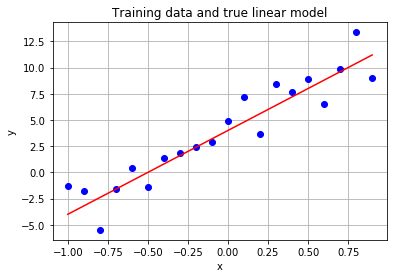

In [8]:
plt.plot(x_tr, y_tr,'ob');
plt.plot(x_tr,(w0_true + w1_true * x_tr),'-r');
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training data and true linear model')
plt.grid()

In [9]:
XX = np.vstack((np.ones(len(x_tr)), x_tr)).T # design matrix (convention Bishop(2006))
nX_tr, mX_tr = XX.shape # - np.array([0, 1]); # data dimensions are defined as actual features ;)

### Test data

In [10]:
x_te = np.arange(start=-1.25, stop=1.25, step=0.1)
XX_te = np.vstack((np.ones(len(x_te)), x_te)).T # design matrix (convention Bishop(2006))
nX_te, mX_te = XX_te.shape # - np.array([0, 1]); # data dimensions are defined as actual features ;)

In [11]:
XX.shape

(20, 2)

## Stan

In [12]:
x_stan = np.ndarray.tolist(XX)
y_stan = np.ndarray.tolist(y_tr)

In [14]:
stan_dat = {'N': nX_tr,
            'K': mX_tr,
            'x': x_stan,
            'y': y_stan}

In [21]:
stan_code = """
data {
  int<lower=0> N;   // number of data items
  int<lower=0> K;   // number of inputs
  matrix[N, K] x;   // input matrix
  vector[N] y;      // output vector
}
parameters {
  vector[K] w;       // coefficients for inputs
  real<lower=0> sigma;  // error scale
}
model {
  for(k in 1:K)
    w[k] ~ normal(0, 10); // prior for coefficients
  sigma ~ cauchy(0, 5); // prior for error scale
  y ~ normal(x * w, sigma);  // likelihood
}
"""

In [22]:
sm = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_53902d24c60c98535f43f1e5b9d1fc5e NOW.


In [23]:
fit = sm.sampling(data=stan_dat, iter=1000, chains=4, seed=42)

In [24]:
print(fit)

Inference for Stan model: anon_model_53902d24c60c98535f43f1e5b9d1fc5e.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
w[1]    4.21  9.2e-3   0.41   3.42   3.94    4.2   4.48   5.02   1947    1.0
w[2]    7.78    0.02   0.76   6.28   7.31   7.79   8.25    9.3   1822    1.0
sigma   1.87  8.5e-3   0.33   1.35   1.64   1.81   2.05   2.64   1481    1.0
lp__  -21.79    0.05   1.32 -25.04 -22.41 -21.42 -20.84 -20.34    722    1.0

Samples were drawn using NUTS at Tue Apr 28 07:00:57 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [68]:
stan_code2 = """
data {
  int<lower=0> N;   // number of data items
  int<lower=0> K;   // number of inputs
  matrix[N, K] x;   // input matrix
  vector[N] y;      // output vector
}
parameters {
  vector[K] w;              // coefficients for inputs
  vector<lower=0>[K] alpha; // ARD vector (precision)
  real<lower=0> beta;       // error scale (precision)
}
model {
  for(k in 1:K)
    w[k] ~ normal(0, (beta*alpha[k])^(-0.5)); // prior for coefficients
  alpha ~ gamma(2, 2); // ARD vector
  beta ~ gamma(2, 2); // prior for error scale
  y ~ normal(x * w, beta^(-0.5));  // likelihood
}
"""

In [69]:
sm2 = pystan.StanModel(model_code=stan_code2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b30deeae169b7544706f5007aa369662 NOW.


In [70]:
control = {}
control['adapt_delta'] = 0.95
control['max_treedepth'] = 20
fit2 = sm2.sampling(data=stan_dat, iter=1000, chains=4, seed=42, control=control)

In [71]:
print(fit2)

Inference for Stan model: anon_model_b30deeae169b7544706f5007aa369662.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
w[1]       4.11    0.01   0.43   3.22   3.83   4.12    4.4   4.93   1577    1.0
w[2]       7.53    0.02   0.76   6.07   7.05   7.52    8.0   9.05   1909    1.0
alpha[1]   0.57  8.3e-3   0.38   0.08   0.29   0.49   0.75   1.56   2107    1.0
alpha[2]   0.26  5.3e-3    0.2   0.03   0.12   0.21   0.34   0.78   1446    1.0
beta       0.29  2.6e-3   0.09   0.14   0.22   0.28   0.35    0.5   1312    1.0
lp__     -37.44    0.06   1.74 -41.69 -38.31 -37.09 -36.15 -35.24    820    1.0

Samples were drawn using NUTS at Tue Apr 28 07:49:44 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [72]:
np.sqrt(1/0.29)

1.8569533817705186